# Анализ продаж чая и кофе в США

1. Постановка задачи
2. Сбор данных и анализ их качества
3. Предварительныя обработка
4. Визуализация 
5. Создание новых признаков
6. Гипотезы 
7.  Машинное обучение

## Постановка задачи

1. Проанализировать данные и составить графики, которые можно было бы продемонстрировать на дашборде 
2. Оценить корреляционные связи между известными признаками
3. Построить модель, предсказывающую маржинальность продажи кофе и чая по ряду факторов

## Сбор данных и анализ их качества

Тащим данные с кагла с помощью их api, постовляемым в pip пакете kaggle

In [3]:
%%capture pip_log
!pip install kaggle
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"p","key":"k"} 

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d dsfelix/us-stores-sales
!unzip -u us-stores-sales.zip

In [4]:
import pandas as pd
import numpy as np
import numba 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

np.random.seed(2022)
sns.set_style('whitegrid')

sales_data = pd.read_csv('sales.csv')
sales_data

,Area Code,State,Market,Market Size,Profit,Margin,Sales,COGS,Total Expenses,Marketing,Inventory,Budget Profit,Budget COGS,Budget Margin,Budget Sales,ProductId,Date,Product Type,Product,Type
0,203,Connecticut,East,Small Market,107.0,176.0,292.0,116.0,69.0,38.0,962.0,110.0,110.0,160.0,270.0,2,04/01/10 00:00:00,Coffee,Columbian,Regular
1,203,Connecticut,East,Small Market,75.0,135.0,225.0,90.0,60.0,29.0,1148.0,90.0,80.0,130.0,210.0,2,07/01/10 00:00:00,Coffee,Columbian,Regular
2,203,Connecticut,East,Small Market,122.0,195.0,325.0,130.0,73.0,42.0,1134.0,130.0,110.0,180.0,290.0,2,11/01/10 00:00:00,Coffee,Columbian,Regular
3,203,Connecticut,East,Small Market,105.0,174.0,289.0,115.0,69.0,37.0,1166.0,110.0,100.0,160.0,260.0,2,12/01/10 00:00:00,Coffee,Columbian,Regular
4,203,Connecticut,East,Small Market,104.0,135.0,223.0,90.0,56.0,29.0,1148.0,90.0,80.0,130.0,210.0,2,07/01/11 00:00:00,Coffee,Columbian,Regular
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4243,985,Louisiana,South,Small Market,-6.0,66.0,113.0,47.0,72.0,42.0,-395.0,0.0,40.0,50.0,90.0,4,07/01/10 00:00:00,Espresso,Caffe Latte,Regular
4244,985,Louisiana,South,Small Market,-7.0,61.0,105.0,44.0,68.0,39.0,-508.0,10.0,30.0,60.0,90.0,4,08/01/10 00:00:00,Espresso,Caffe Latte,Regular
4245,985,Louisiana,South,Small Market,-3.0,76.0,131.0,55.0,79.0,49.0,-1053.0,0.0,40.0,60.0,100.0,4,12/01/10 00:00:00,Espresso,Caffe Latte,Regular
4246,985,Louisiana,South,Small Market,1.0,87.0,160.0,63.0,86.0,57.0,37.0,0.0,50.0,70.0,120.0,4,04/01/11 00:00:00,Espresso,Caffe Latte,Regular


## Предварительныя обработка

В выгруженном датасете 20 колонок, их содержимое из источника:


* Area Code: Код магазина(внутренняя нумерация);
* State: Штат, в котором находится магазин;
* Market: Регион, в котором находится магазин;
* Market Size: Размер магазина;
* Profit: Выручка в долларах (\$);
* Margin: Profit + Total Expenses (\$) ИЛИ Sales - COGS (\$);
* Sales: Values Acquired in Sales (\$);
* COGS: Себестоимость реализованной продукции(Cost of Goods Sold) (\$);
* Total Expenses: Total Expenses to get the Product to Sell (\$);
* Marketing: Затраты на маркетинг (\$);
* Inventory: Inventory Value of the Product in the Sale Moment (\$);
* Budget Profit: Expected Profit (\$);
* Budget COGS: Expected COGS (\$);
* Budget Margin: Expected Profit + Expected Total Expenses (\$) ИЛИ Expected Sales * - Expected COGS (\$);
* Budget Sales: Expected Value Acquired in Sales ($);
* ProductID: ID товара;
* Date: Дата продажи;
* Product Type: Категория товара;
* Product: Описание товара;
* Type: Тип товара;

Изучим, в каком виде они представлены в таблице

In [5]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4248 entries, 0 to 4247
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Area Code       4248 non-null   int64  
 1   State           4248 non-null   object 
 2   Market          4248 non-null   object 
 3   Market Size     4248 non-null   object 
 4   Profit          4248 non-null   float64
 5   Margin          4248 non-null   float64
 6   Sales           4248 non-null   float64
 7   COGS            4248 non-null   float64
 8   Total Expenses  4248 non-null   float64
 9   Marketing       4248 non-null   float64
 10  Inventory       4248 non-null   float64
 11  Budget Profit   4248 non-null   float64
 12  Budget COGS     4248 non-null   float64
 13  Budget Margin   4248 non-null   float64
 14  Budget Sales    4248 non-null   float64
 15  ProductId       4248 non-null   int64  
 16  Date            4248 non-null   object 
 17  Product Type    4248 non-null   o

Два категориальных признака в зашифрованном состоянии хранятся в формате int64, остальные 6 в строковом формате; дата записана в строке  и все денежные значения предствалены в формате чисел с плаающей запятой. 

В детасете все денежные значения указаны в формате float64, при этом округлены до единиц. Убедимся в этом и переведём в целочисленный формат все цены, если это допустимо.

In [6]:
def convert_to_int64(dataset, name: str):
    if all((value % 1) == 0 for value in dataset[name]):
        dataset[name] = dataset[name].convert_dtypes(convert_integer=True) 

convert_to_int64(sales_data, 'Profit')
convert_to_int64(sales_data, 'Margin')
convert_to_int64(sales_data, 'Sales')
convert_to_int64(sales_data, 'COGS')
convert_to_int64(sales_data, 'Total Expenses')
convert_to_int64(sales_data, 'Marketing')
convert_to_int64(sales_data, 'Inventory')
convert_to_int64(sales_data, 'Budget Profit')
convert_to_int64(sales_data, 'Budget COGS')
convert_to_int64(sales_data, 'Budget Margin')
convert_to_int64(sales_data, 'Budget Sales')

sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4248 entries, 0 to 4247
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Area Code       4248 non-null   int64 
 1   State           4248 non-null   object
 2   Market          4248 non-null   object
 3   Market Size     4248 non-null   object
 4   Profit          4248 non-null   Int64 
 5   Margin          4248 non-null   Int64 
 6   Sales           4248 non-null   Int64 
 7   COGS            4248 non-null   Int64 
 8   Total Expenses  4248 non-null   Int64 
 9   Marketing       4248 non-null   Int64 
 10  Inventory       4248 non-null   Int64 
 11  Budget Profit   4248 non-null   Int64 
 12  Budget COGS     4248 non-null   Int64 
 13  Budget Margin   4248 non-null   Int64 
 14  Budget Sales    4248 non-null   Int64 
 15  ProductId       4248 non-null   int64 
 16  Date            4248 non-null   object
 17  Product Type    4248 non-null   object
 18  Product 

Превосходно, теперь все ценовые столбцы успешно успешно конвертированы.

Теперь изучим категориальные признаки, представленные строками: 

In [7]:
categories = ['State', 'Market', 'Market Size', 'Product Type', 'Product', 'Type']
for category in categories:
    print(f'{category}:', sales_data[category].unique(), '\n')

State: ['Connecticut' 'Washington' 'California' 'Texas' 'New York' 'Ohio'
 'Illinois' 'Louisiana' 'Florida' 'Wisconsin' 'Colorado' 'Missouri' 'Iowa'
 'Massachusetts' 'Oklahoma' 'Utah' 'Oregon' 'New Mexico' 'New Hampshire'
 'Nevada'] 

Market: ['East' 'West' 'South' 'Central'] 

Market Size: ['Small Market' 'Major Market'] 

Product Type: ['Coffee' 'Tea' 'Espresso' 'Herbal Tea'] 

Product: ['Columbian' 'Green Tea' 'Caffe Mocha' 'Decaf Espresso' 'Lemon' 'Mint'
 'Darjeeling' 'Decaf Irish Cream' 'Chamomile' 'Earl Grey' 'Caffe Latte'
 'Amaretto' 'Regular Espresso'] 

Type: ['Regular' 'Decaf'] 



Для колонок, в которых есть большое число различных уникальных значений (State и Product), в датасете есть числовые представления (столбцы Area Code и ProductId соответственно), а остальные имеют малое число уникальных значений.

Теперь исследуем столбец с датами: 

In [8]:
pd.to_datetime(sales_data['Date']).unique()

array(['2010-04-01T00:00:00.000000000', '2010-07-01T00:00:00.000000000',
       '2010-11-01T00:00:00.000000000', '2010-12-01T00:00:00.000000000',
       '2011-07-01T00:00:00.000000000', '2011-08-01T00:00:00.000000000',
       '2011-09-01T00:00:00.000000000', '2011-10-01T00:00:00.000000000',
       '2011-11-01T00:00:00.000000000', '2010-06-01T00:00:00.000000000',
       '2010-10-01T00:00:00.000000000', '2011-01-01T00:00:00.000000000',
       '2011-02-01T00:00:00.000000000', '2011-03-01T00:00:00.000000000',
       '2011-04-01T00:00:00.000000000', '2011-05-01T00:00:00.000000000',
       '2011-12-01T00:00:00.000000000', '2010-02-01T00:00:00.000000000',
       '2010-05-01T00:00:00.000000000', '2010-08-01T00:00:00.000000000',
       '2010-03-01T00:00:00.000000000', '2010-09-01T00:00:00.000000000',
       '2011-06-01T00:00:00.000000000', '2010-01-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

Для каждого значения за первое число месяца => данные приведены за месяц и, соответственно, день, час и т.д. не несут информации. Соответстенно конвертируем данные в соотвтетсвующий формат date

In [9]:
sales_data['Date'] = pd.to_datetime(sales_data['Date']).dt.to_period('m')

Посмотрим на полученные данные

In [10]:
sales_data.head()

,Area Code,State,Market,Market Size,Profit,Margin,Sales,COGS,Total Expenses,Marketing,Inventory,Budget Profit,Budget COGS,Budget Margin,Budget Sales,ProductId,Date,Product Type,Product,Type
0,203,Connecticut,East,Small Market,107,176,292,116,69,38,962,110,110,160,270,2,2010-04,Coffee,Columbian,Regular
1,203,Connecticut,East,Small Market,75,135,225,90,60,29,1148,90,80,130,210,2,2010-07,Coffee,Columbian,Regular
2,203,Connecticut,East,Small Market,122,195,325,130,73,42,1134,130,110,180,290,2,2010-11,Coffee,Columbian,Regular
3,203,Connecticut,East,Small Market,105,174,289,115,69,37,1166,110,100,160,260,2,2010-12,Coffee,Columbian,Regular
4,203,Connecticut,East,Small Market,104,135,223,90,56,29,1148,90,80,130,210,2,2011-07,Coffee,Columbian,Regular


## Визуализация 

In [11]:
sales_data.drop(columns=['ProductId', 'Area Code']).describe(percentiles=[.1, .25, .5, 0.75, 0.9, 0.99])

,Profit,Margin,Sales,COGS,Total Expenses,Marketing,Inventory,Budget Profit,Budget COGS,Budget Margin,Budget Sales
count,4248.0,4248.0,4248.0,4248.0,4248.0,4248.0,4248.0,4248.0,4248.0,4248.0,4248.0
mean,61.097693,104.293315,192.987524,84.433145,54.063559,31.185028,749.381356,60.913371,74.830508,100.819209,175.649718
std,101.708546,94.342522,151.133127,67.249769,32.352598,27.023264,661.031896,79.546123,66.238145,92.602725,148.891522
min,-638.0,-302.0,17.0,0.0,10.0,0.0,-3534.0,-320.0,0.0,-210.0,0.0
10%,-4.0,34.0,63.0,28.0,19.0,8.0,312.0,10.0,20.0,30.0,50.0
25%,17.0,52.75,100.0,43.0,33.0,13.0,432.0,20.0,30.0,50.0,80.0
50%,40.0,76.0,138.0,60.0,46.0,22.0,619.0,40.0,50.0,70.0,130.0
75%,92.0,132.0,230.0,100.0,65.0,39.0,910.5,80.0,90.0,130.0,210.0
90%,171.0,222.0,387.0,200.0,102.0,74.0,1310.0,140.0,170.0,200.0,360.0
99%,389.06,428.0,693.0,294.0,152.0,120.0,3076.0,360.0,320.0,470.0,740.0


Выводы:
1. В датасете есть отрицательные значения в столбце Inventory, но это невозможно, т.к. нельзя хранить отрицельное число единиц товара. Заменем все отрицательные числа нулями 
2. Для большинства столбцов среднеквадратическое отклонение превосходит 50-й перцентиль, что говорит о выбросах (90-й, 99-й и 100-й перцентиль тоже подтверждают).

In [12]:
sales_data['Inventory'] = sales_data['Inventory'].apply(lambda x: x if x >= 0 else 0)
sales_data[['Inventory']].describe()

,Inventory
count,4248.000000
mean,769.115348
std,610.080105
min,0.000000
25%,432.000000
50%,619.000000
75%,910.500000
max,8252.000000


Рассмотрим категориальные значения

In [13]:
sales_data.describe(include=['object'])

,State,Market,Market Size,Product Type,Product,Type
count,4248,4248,4248,4248,4248,4248
unique,20,4,2,4,13,2
top,Utah,West,Small Market,Espresso,Columbian,Regular
freq,288,1344,2544,1176,480,2400


In [14]:
descr = sales_data.describe(include=['object'])
descr.loc['loc'] = (descr.loc['freq'] / descr.loc['count']) * descr.loc['unique']
descr 

,State,Market,Market Size,Product Type,Product,Type
count,4248,4248,4248,4248,4248,4248
unique,20,4,2,4,13,2
top,Utah,West,Small Market,Espresso,Columbian,Regular
freq,288,1344,2544,1176,480,2400
loc,1.355932,1.265537,1.19774,1.107345,1.468927,1.129944


Посмотрим на корреляцию между значениями

In [15]:
sales_data['Month'] = sales_data['Date'].apply(lambda x : x.month) 
sales_data.corr()

<ipython-input-15-6ea98bd9b3a3>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sales_data.corr()


,Area Code,Profit,Margin,Sales,COGS,Total Expenses,Marketing,Inventory,Budget Profit,Budget COGS,Budget Margin,Budget Sales,ProductId,Month
Area Code,1.000000,0.013979,0.029278,0.055220,0.080471,0.044552,0.051232,0.082893,0.011994,0.063720,0.022871,0.042572,2.429694e-02,1.348084e-02
Profit,0.013979,1.000000,0.920604,0.797331,0.464838,0.199976,0.225465,-0.035389,0.937606,0.479862,0.876844,0.758830,-5.869339e-02,8.030853e-03
Margin,0.029278,0.920604,1.000000,0.938809,0.678797,0.521254,0.531947,0.123208,0.922812,0.680549,0.963460,0.901981,-7.959521e-02,1.276869e-02
Sales,0.055220,0.797331,0.938809,1.000000,0.886651,0.689350,0.710515,0.386915,0.815435,0.862882,0.920757,0.956538,-4.807745e-02,1.071546e-02
COGS,0.080471,0.464838,0.678797,0.886651,1.000000,0.782534,0.818271,0.667762,0.514967,0.947762,0.688587,0.849901,2.142304e-03,1.463609e-02
Total Expenses,0.044552,0.199976,0.521254,0.689350,0.782534,1.000000,0.966167,0.471480,0.255811,0.744259,0.530776,0.661217,-7.336890e-02,6.231384e-03
Marketing,0.051232,0.225465,0.531947,0.710515,0.818271,0.966167,1.000000,0.534155,0.279315,0.773709,0.543039,0.681946,-4.222699e-02,1.377227e-02
Inventory,0.082893,-0.035389,0.123208,0.386915,0.667762,0.471480,0.534155,1.000000,0.037206,0.619266,0.177629,0.385972,4.001659e-02,1.321218e-01
Budget Profit,0.011994,0.937606,0.922812,0.815435,0.514967,0.255811,0.279315,0.037206,1.000000,0.579176,0.949637,0.848285,-1.477584e-01,7.596332e-03
Budget COGS,0.063720,0.479862,0.680549,0.862882,0.947762,0.744259,0.773709,0.619266,0.579176,1.000000,0.750422,0.911598,-1.566830e-01,8.278223e-03


<ipython-input-16-558f2c90c94a>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = sales_data.drop(columns=['ProductId', 'Area Code']).corr()


[Text(0.5, 1.0, 'Heatmap of financial parameters relation')]

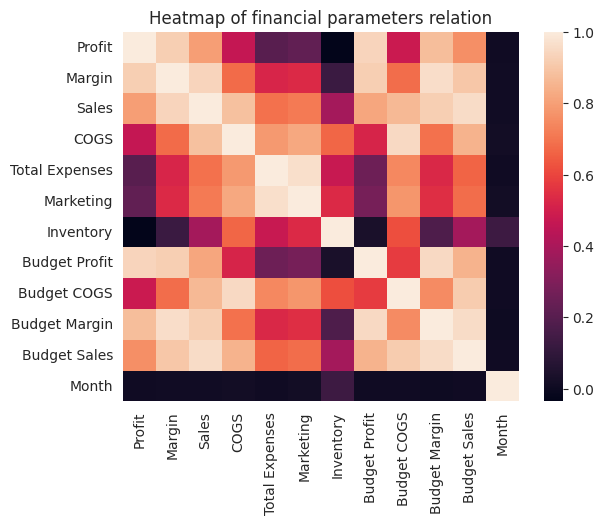

In [16]:
corr = sales_data.drop(columns=['ProductId', 'Area Code']).corr()
sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns).set(title='Heatmap of financial parameters relation')

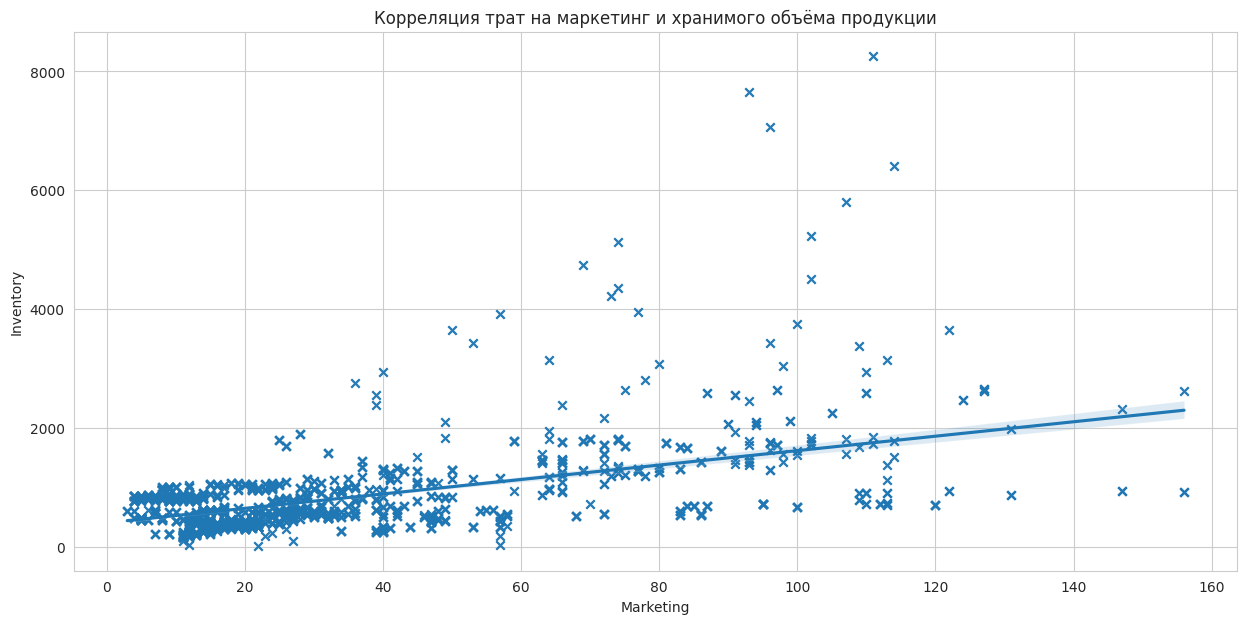

In [17]:
plt.figure(figsize=(15,7))
plt.title('Корреляция трат на маркетинг и хранимого объёма продукции')

plt.xlabel('Маркетинг (USD$)')
plt.ylabel('Объём(ед.)')

sns.regplot(x=sales_data['Marketing'].astype('float64').apply(lambda x : x if x > 0 else None), 
    y=sales_data['Inventory'].astype('float64').apply(lambda x : x if x > 0 else None), 
    marker='x')

plt.show()

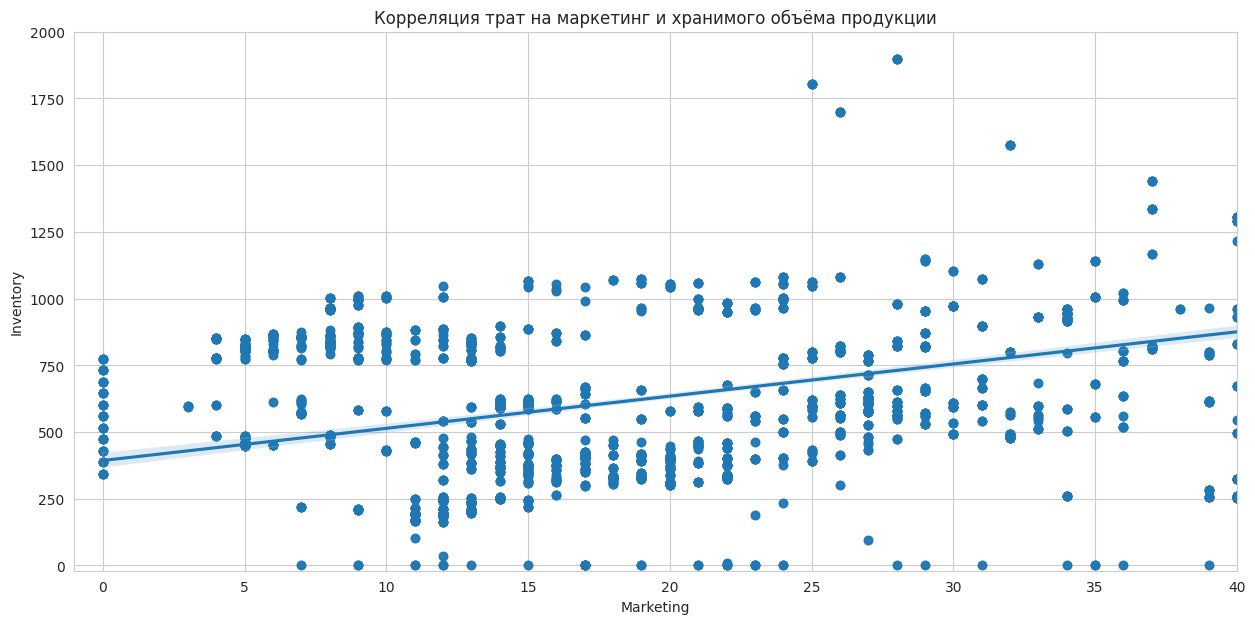

In [18]:
plt.figure(figsize=(15,7))
plt.title('Корреляция трат на маркетинг и хранимого объёма продукции')

plt.xlabel('Маркетинг (USD$)')
plt.ylabel('Объём(ед.)')

graphobj = sns.regplot(
    x=sales_data['Marketing'].astype('float64'), 
    y=sales_data['Inventory'].astype('float64'))

graphobj.set(xlim=(-1, 40), ylim=(-20, 2000))

plt.show()

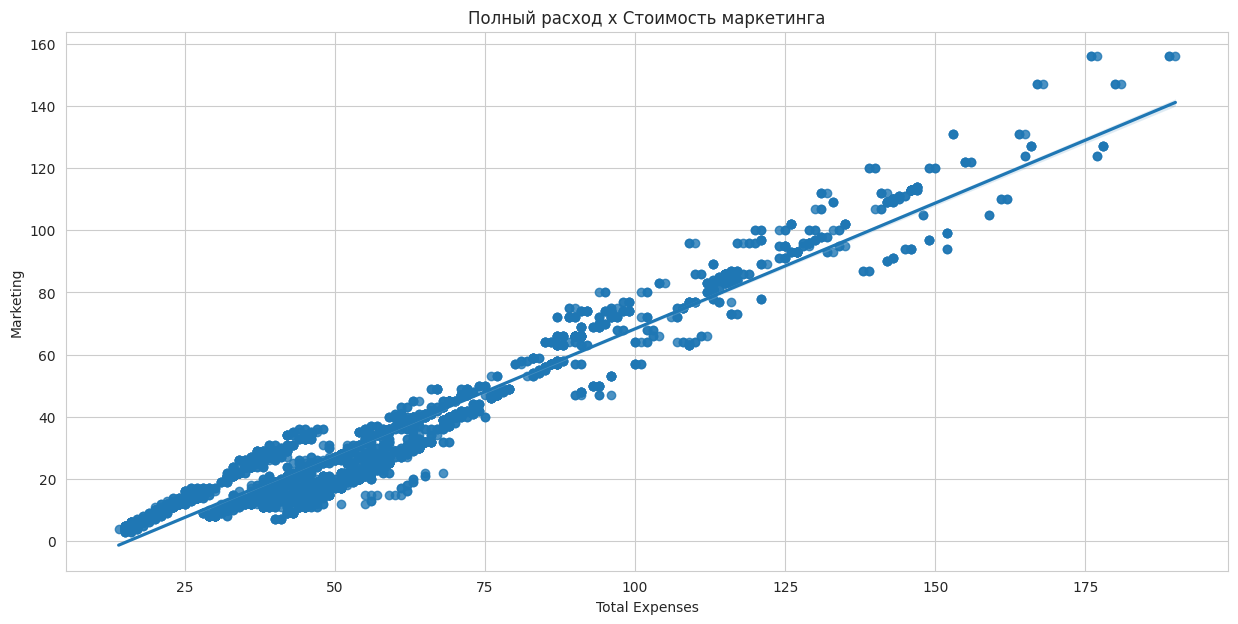

In [19]:
plt.figure(figsize=(15,7))
plt.title('Полный расход x Стоимость маркетинга')

plt.xlabel('Расход (U$)')
plt.ylabel('Маркетинг (U$)')

sns.regplot( 
    x=sales_data['Total Expenses'].astype('float64').apply(lambda x : x if x > 0 else None), 
    y=sales_data['Marketing'].astype('float64').apply(lambda x : x if x > 0 else None))

plt.show()

<Axes: title={'center': 'Траты на маркетинг x Месяц'}, xlabel='Month', ylabel='Marketing'>

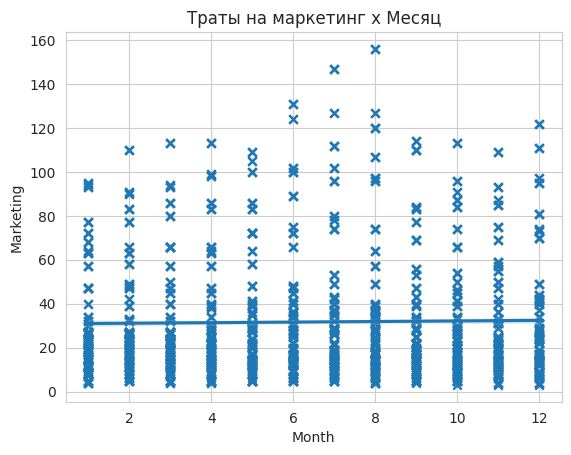

In [21]:
plt.title('Траты на маркетинг x Месяц')

plt.xlabel('Месяц')
plt.ylabel('Траты на Маркетинг (U$)')

sns.regplot(
    y=sales_data['Marketing'].astype('float64').apply(lambda x : x if x > 0 else None), 
    x=sales_data['Month'].astype('float64').apply(lambda x : x if x > 0 else None), 
    marker='x')

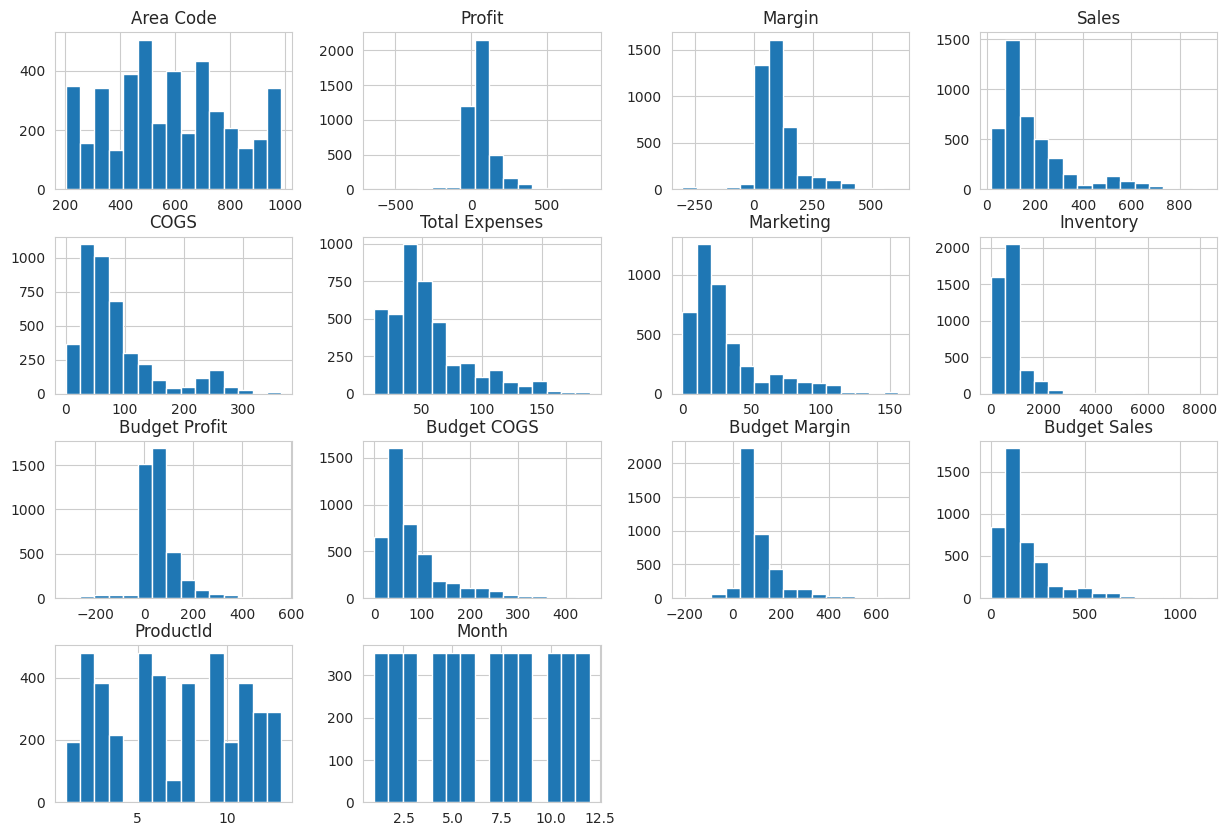

In [22]:
sales_data.hist(bins=15, figsize=(15, 10));

<ipython-input-24-b3a31e1aa351>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sales_trend_data = sales_data.groupby(['State', 'Month']).sum()


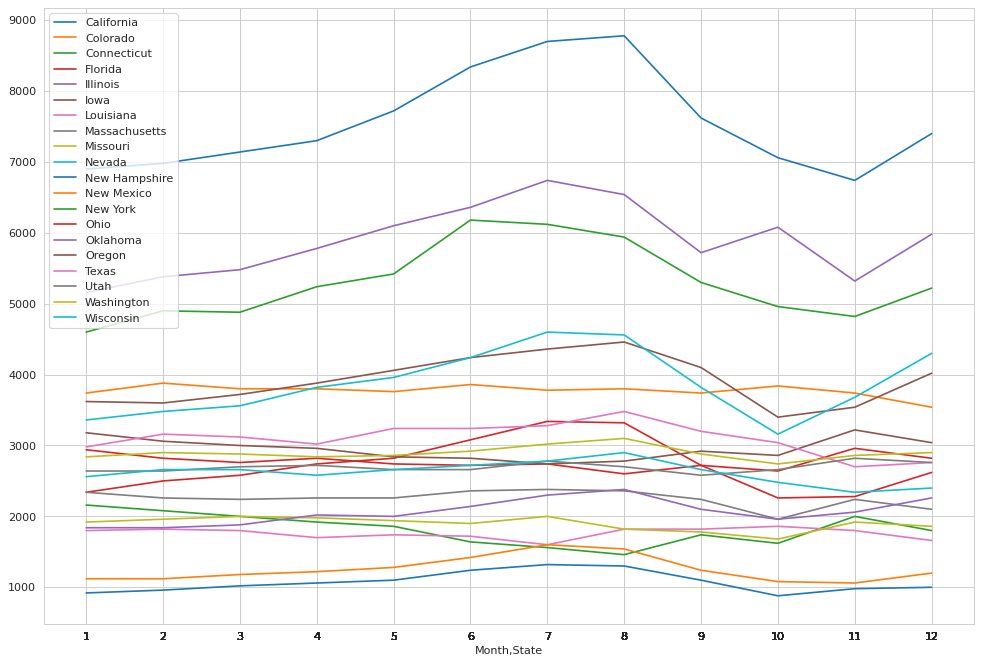

In [24]:
fig, ax = plt.subplots(figsize=(15, 10), dpi=80)

sales_trend_data = sales_data.groupby(['State', 'Month']).sum()
sales_trend_data = sales_trend_data.reset_index()
sales_trend_data.set_index(['Month', 'State'], inplace=True)
sales_trend_data['Budget Sales'].groupby('State').plot(legend=True)
sales_trend_data = sales_trend_data.reset_index()
sales_trend_data.set_index('Month', inplace=True)
ax.set_xticks(sales_trend_data.index-1)
sales_trend_data = sales_trend_data.reset_index()
ax.set_xticklabels(sales_trend_data['Month'])
plt.show()

## Создание новых признаков


* Есть месяц
* (будет) средняя температура по месяцам в штате
* (будет) бюджет штата/численность населения
* (будет) затраты на маркетинг/бюджет

## Гипотезы 


1. Летом возрастает стоимость крупных закупок. 
2. Штат влияет на продажи

## Машинное обучение